 Libraries imported successfully.

 2. Data Imported Successfully from UCI Repository

 3. & 4. Starting Data Cleaning and Preprocessing
Missing values filled.
Binary target column 'HeartDisease' created.
Cleaned 'chol' column.

 5. Performing Feature Engineering (One-Hot Encoding)
Categorical features encoded.

 6. & 7. Splitting Data
Training set: 242 samples | Testing set: 61 samples

 8. Balancing Training Data with SMOTE

 9. Scaling Features

 10. & 11. Training and Evaluating Baseline Models

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        33
           1       0.80      0.86      0.83        28

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


--- Decision Tree Performance ---
              precision    recall  f1-score   support

           0       0.88      0.85     

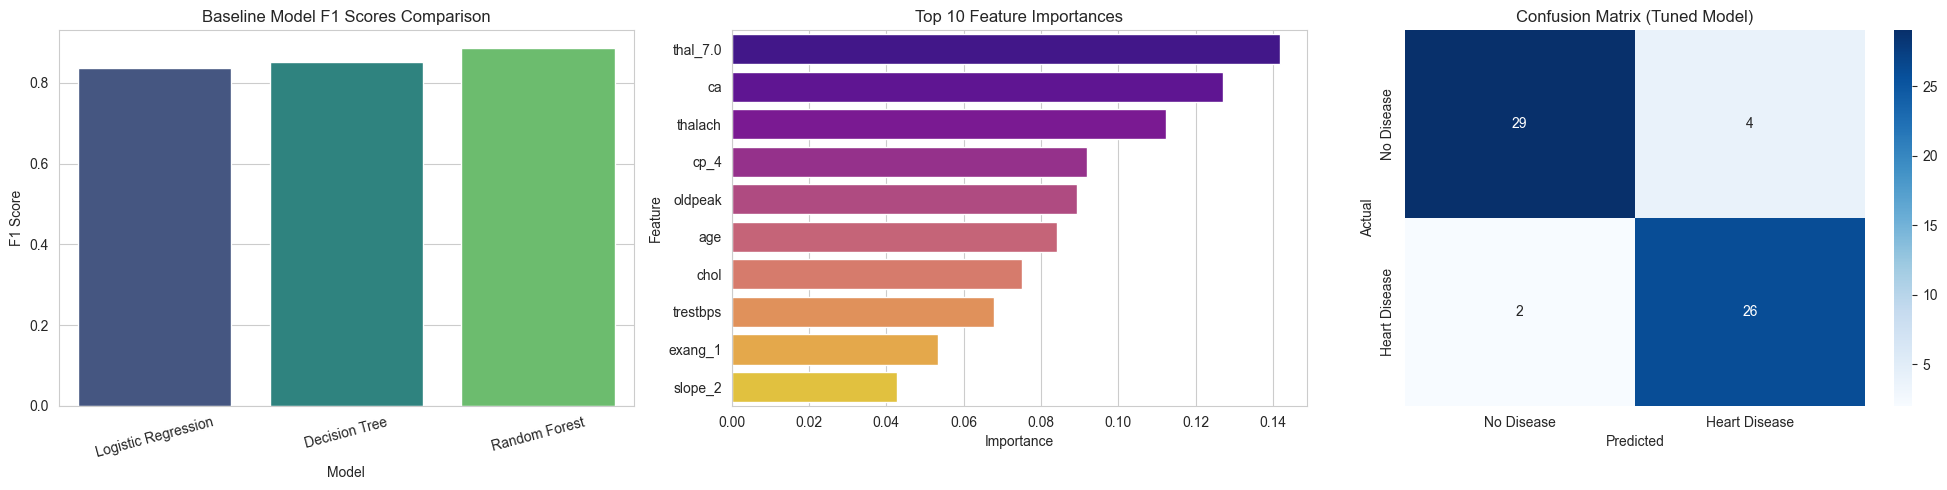

In [1]:
# 1.Library 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib #Model saving
from ucimlrepo import fetch_ucirepo #Fetching dataset
from imblearn.over_sampling import SMOTE #Handling imbalanced data
#2 Data Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(" Libraries imported successfully.")

# ye fetch kar raha ha dataset from UCI repository
heart_disease = fetch_ucirepo(id=45)
X_data = heart_disease.data.features
y_data = heart_disease.data.targets

# Ye combine kar raha ha ek single dataframe main
df = pd.concat([X_data, y_data], axis=1)
print("\n 2. Data Imported Successfully from UCI Repository")

# 3. & 4. Data Cleaning and Preprocessing
print("\n 3. & 4. Starting Data Cleaning and Preprocessing")

# Handle missing values by filling with the median
for col in df.columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
print("Missing values filled.")

# Create a binary 'HeartDisease' target column (0 = No Disease, 1 = Yes)
df['HeartDisease'] = (df['num'] > 0).astype(int)
df = df.drop('num', axis=1)
print("Binary target column 'HeartDisease' created.")

# Replace 0 values in 'chol' (ye cholesterol level hai) with the median
median_chol = df['chol'][df['chol'] != 0].median()
df['chol'] = df['chol'].replace(0, median_chol)
print("Cleaned 'chol' column.")

# 5. Feature Engineering (Encoding)
print("\n 5. Performing Feature Engineering (One-Hot Encoding)")
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # Converts categorical columns into numeric format for ML.
print("Categorical features encoded.")

# 6. & 7. Feature/Target Split and Train/Test Split
print("\n 6. & 7. Splitting Data")
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]} samples | Testing set: {X_test.shape[0]} samples")

# 8. Data Balancing (SMOTE)
print("\n 8. Balancing Training Data with SMOTE")
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train) #equal kar raha hai (matble 80-20 ko 50-50 kar raha hai)

# 9. Feature Scaling
print("\n 9. Scaling Features")
scaler = StandardScaler() #Ye sare features ko same scale main kar deta hai (mean=0, std=1) for better work.
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# 10. & 11. Model Selection and Evaluation
print("\n 10. & 11. Training and Evaluating Baseline Models")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Store results for comparison plot
model_performance = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_sm)
    y_pred = model.predict(X_test_scaled)
    
    # Store performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_performance.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1})
    
    print(f"\n--- {name} Performance ---")
    print(classification_report(y_test, y_pred))
# Convert performance list to a DataFrame for easy plotting
performance_df = pd.DataFrame(model_performance)

# 12. Feature Importance
print("\n 12. Calculating Feature Importance")
#Use the baseline Random Forest model for feature importance calculation
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Top 5 most important features:\n", feature_importance_df.head())

# 13. Final Model Tuning (Hyperparameter Tuning)
print("\n 13. Tuning the Random Forest Model with GridSearchCV")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train_sm)
best_rf = grid_search.best_estimator_
print("Best Parameters found:", grid_search.best_params_)


# 14. Saving the Model (Optional for Deployment)
print("\n 14. Saving Final Model and Scaler for Deployment")
joblib.dump(best_rf, 'heart_disease_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Model saved as 'heart_disease_model.joblib'")
print("Scaler saved as 'scaler.joblib'")

# 15. Visualization of Results
print("\n 15. Generating Final Visualizations")

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(20, 5))

# Plot 1: Compare multiple model performances side-by-side
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='F1 Score', data=performance_df, hue='Model', palette='viridis', legend=False)
plt.title('Baseline Model F1 Scores Comparison')
plt.xticks(rotation=15)

# Plot 2: Visualize feature importance
plt.subplot(1, 3, 2)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), hue='Feature', palette='plasma', legend=False)
plt.title('Top 10 Feature Importances')

# Plot 3: Plot confusion matrix for the final tuned model
y_pred_tuned = best_rf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_tuned)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Heart Disease'],
            yticklabels=['No Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned Model)')

plt.tight_layout()
plt.show()

In [1]:
'''To build a secure, smart banking system where users can register and login using face recognition (via OpenCV), and then perform banking operations like deposit, withdraw, balance check, and transaction history — all stored in MySQL.Modules & Features:
 1. User Management
Register new user with:

Name

Face photo (OpenCV)

Email/Phone

Password

Facial authentication login (OpenCV + Haar Cascade)

Secure user data storage (MySQL)

 2. Banking Operations
Deposit money

Withdraw money

Check balance

Transfer to another account
Transaction history

Admin dashboard to manage users

 3. Security & Verification
Facial recognition as login authentication (OpenCV)

Password-based fallback (if face not detected)

Error handling and logging

 Tech Stack & Requirements
🔹 Python Modules:
opencv-python

mysql-connector-python

numpy

datetime
'''
import mysql.connector
from mysql.connector import Error
import os 
from PIL import Image
from deepface import DeepFace
import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#database connection

mydb = mysql.connector.connect(
            host="localhost",
            user="root",
            password="1234567890",
            database="bank"
        )

mycursor = mydb.cursor()
#folder to store registered image
os.makedirs("userfaces",exist_ok=True)

#----user registration----
def capture_photo(filename="captured.jpg"):
    cap=cv2.VideoCapture(0)
    while True:
        ret,frame=cap.read()
        cv2.imshow("Press space to capture photo",frame)
        #press spca to capture 
        if cv2.waitKey(1)&0xFF==ord(' '):  
            print("photo captured Enter you name:")
            name=input().strip()
            if name:
                filename=f"userface{name}.jpg"
                cv2.imwrite(filename,frame)
                print(f"photo save as:{filename}")
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
                plt.imshow(img)
                plt.title(f"Saved: {name}.jpg")
                plt.axis('off')
                plt.show()
            else:
                print("no name was provided,photo not saved")
            break
    cap.release()
    cv2.destroyAllWindows()
    return filename


def register_user():
    print("\n--- USER REGISTRATION ---")
    print("Capturing user's photo")
    photo_path=capture_photo()
    name=input("Enter you name").strip()
    email=input("Enter your email id").strip()
    phone=(input("Enter your phone number")).strip()
    Pass=input("Enter your password").strip()
   
    try:
        mycursor.execute("INSERT INTO  user (Name,Phone,Email,PASSWORD) VALUES(%s,%s,%s,%s)",(name,phone,email,Pass))
        mydb.commit()
        print("-------------------")

        print("REGISTRATION SUCCESSFUL!!!")
        print("-------------------")

        mycursor.execute("SELECT * FROM user")
        user_records = mycursor.fetchall()
        print("\nCurrent Users:")
        print("ID | Name | Phone | Email")
        print("--------------------------")
        for user in user_records:
            print(f"{user[0]}||{user[1]}||{user[2]}||{user[3]}||")
        
    except Error as err:
        print(f"Database error: {err}")

#face login
def face_login():
    print("\nFace Recognition Login")
    print("LOOK AT THE CAMERA")
    print("---------------------")
    #capture current faace
    cap=cv2.VideoCapture(2)
    ret,current_Face=cap.read()
    cap.release()
#compare with registered face
    mycursor.execute("SELECT photopath FROM user")
    for (photo_path,) in mycursor:
        stored_face=cv2.imread(photo_path)
        if stored_face is not None and np.array_equal(current_Face, stored_face):
            return True
    return False

#password login
def password_login():
    email=input("Enter your email :")
    password=input("Enter your password :")
    mycursor.execute("SELECT * FROM user WHERE email = %s and PASSWORD=%s", (email,password))
    return mycursor.fetchone() is not None

#login
def login():
    if face_login():
        print("Face recognized! Login successful.")
        return True
    else:
        print("Face not recognized. Trying password login...")
    if password_login():
        print("Password accepted! Login successful.")
        return True
    else:
        print("Login failed.")
        return False

#----ATM OPERATIONS---------
class ATM:
    def __init__(self, balance=5000, pin="1234"):
        self.balance = balance
        self.pin = pin
        self.transactions = []
    
        
    
    def process(self):
        
        print("\n--- BANKING SERVICES ---")
        print("Insert your card ('card' to continue): ")
        card = input().lower()
        
        if card=="card":
            
            entered_pin = input("Enter your pin(1234): ")
            
            if entered_pin == self.pin:
                while True:
                    print("\n\n1.)Check balance")
                    
                    print("2.)Withdraw money")
                    print("3.)Deposit money")
                    print("4.)Transfer to another account")
                    print("5.) CheckTransaction history")
                    print("6.) Exit")
                    option = int(input("Select your option: "))
                
                    if option == 1:
                        print("Your current balance is:", self.balance)
                    elif option == 2:
                        user_amount = int(input("Enter your amount: "))
                        if user_amount <= self.balance:
                            self.balance -= user_amount
                            print("Your balance is:", self.balance - user_amount)
                            self.transactions.append(f"{datetime.now().strftime('%Y-%m-%d %H:%M')} - Withdrew: {user_amount}")
                        else:
                            print("Insufficient funds.")
                    elif option==3:
                        user_amount = int(input("Enter your amount: "))
                        self.balance += user_amount
                        print("AMOUNT SUCCESSFULLY ADDED TO YOUR ACCOUNT!!!!!!")
                        self.transactions.append(f"{datetime.now().strftime('%Y-%m-%d %H:%M')} - Deposited: {user_amount}")
                    elif option==4:
                        user_amount = int(input("Enter your amount: "))
                        if user_amount <= self.balance:
                            acc = input("Enter account number to transfer to: ")
                            self.balance -= user_amount  # Actually update balance
                            self.transactions.append(f"{datetime.now().strftime('%Y-%m-%d %H:%M')} - Transferred: {user_amount} to account {acc}")
                            print(f"Transfer successful. New balance: {self.balance}")
                        else:
                            print("Insufficient funds.")
                
                    elif option==5:
                        print("\nTransaction History:")
                        print("---------------------")
                        if not self.transactions:
                            print("No transactions recorded.")
                        else:
                            for i ,transaction in enumerate(self.transactions,1):
                                print(f"{i}.{transaction}")
                            print(f"\nCurrent Balance{self.balance}")
                
                    else:
                        print("Invalid option selected.")
                        break

            else:
                print("Wrong pin")
        else:
            print("Invalid card")
            
def main():
    print("\t\t|                   |")
    print("\t\tWELCOME TO OUR BANK")
    print("\t\t-------------------")
    while True:
        print("\n1. Register")
        print("2. Login")
        print("3. Exit")
        choice = input("Select option: ")
        
        if choice == '1':
            register_user()
        elif choice == '2':
            if login():
                atm = ATM()
                atm.process()
        elif choice == '3':
            print("Thank you for using our bank!")
            print("-------------------")

            break
        else:
            print("Invalid choice")
if __name__=="__main__":
    try:
        main()
    finally:
        if mydb.is_connected():
            mycursor.close()
            mydb.close()

ModuleNotFoundError: No module named 'deepface'